In [ ]:
#@title **1: Install packages**
#@markdown Press PLAY **after** and wait for step to finish before moving on.
#@markdown This step takes 5-10 minutes. So enjoy the video below, while waiting.


# install packages
install.packages("bio3d", quietly = TRUE)
install.packages("XML", quietly = TRUE)
install.packages("RCurl", quietly = TRUE)
install.packages("ggseqlogo", quietly = TRUE)


# load packages
library(tidyverse, quietly = TRUE, warn.conflicts = FALSE)
library(bio3d, quietly = TRUE, warn.conflicts = FALSE)
library("XML", "RCurl", quietly = TRUE, warn.conflicts = FALSE)
library(ggseqlogo, quietly = TRUE, warn.conflicts = FALSE)

# create the outputs directory
dir.create("outputs")


# Part 1: Analyzing and visualizing information in a PDB file


Video on [Structural Bioinformatics](https://www.youtube.com/watch?v=lLLXkdTl8aQ) and [Part 2](https://www.youtube.com/watch?v=8GO9kUOPfMQ), if the process takes longer to run.


---

When the previous code block is finished, we can move to importing a structure and analyzing the data in that file. In this first step, we will use the Bio3D package and an internal function called `read.pdb` to import a structure from the [RCSB Protein DataBank or PDB](https://www.rcsb.org/). For Part 1, we will just use the information within the file.

In the example, we will use the file 1Q6C which is a beta-amylase enzyme found in soybeans characterized by Hirata and coworkers. However, you can use whatever file you wish.

---


1Q6C reference:

Hirata, A.; Adachi, M.; Sekine, A.; Kang, Y. N.; Utsumi, S.; Mikami, B. Structural and Enzymatic Analysis of Soybean β-Amylase Mutants with Increased pH Optimum. J. Biol. Chem. 2004, 279 (8), 7287–7295.
  


In [ ]:
# load in the pdb file
# replace the ____ with "1q6c" in the parenthesis
pdb <- read.pdb(____)

  Note: Accessing on-line PDB file


# Select the target chain within the PDB file

If your target PDB has multiple chains or proteins in it, we will need to focus on one chain at a time. Select the appropriate chain name and put that in where it says `chain = "XXX"`. Usually the chain name is A or B, etc.

If you have a monomeric protein, put in "A" in the chain part and run the code block.

In [ ]:
# select the chain
inds <- atom.select(pdb, chain = "xxx")

# trim the pdb file to just the chain
pdb2 <- trim.pdb(pdb, inds)

# select just the c-alphas for now
ca.inds <- atom.select(pdb2, "calpha")

# Plot the B-factors and secondary structure

### For files from the Protein Data Bank
B-factors or temperature factors are an indicator of the flexibility of a molecule in the crystal. They can give a sense of the local confidence in the placement of atoms within the structure as well. Low B-factors are associated with lower flexibility while higher B-factors are associated with higher dynamics or flexibility.

### For model files from AlphaFold3 or similar
Frequently, modeling programs put confidence values in the B-factor column of a PDB file. The most common confidence number is the pLDDT score which measures the per residue confidence. The scale typically runs from 0-100. Low pLDDT scores mean low confidence, while higher scores are associated with high confidence.


For more information on pLDDT, see [pLDDT: Understanding local confidence](https://www.ebi.ac.uk/training/online/courses/alphafold/inputs-and-outputs/evaluating-alphafolds-predicted-structures-using-confidence-scores/plddt-understanding-local-confidence/).



---
In this step, we will extract the B-factors/pLDDT scores from the PDB file and then create a data frame. This data frame will be saved in the outputs folder as a .csv and we will use it to create a plot of the B-factors.


In [ ]:
# extract the b-factor data
bf <- pdb2$atom$b[ca.inds$atom]

# create a dataframe with the b-factor data
# seq() create a series of numbers based on the from and to numbers with a step size of by
bfac_df <- tibble(resnum = seq(from = 1, to = length(bf), by = 1),
                  bfactor = bf)

# create an outputs directory and save a spreadsheet in there called b_factors
# save the file in the outputs folder

write_csv(bfac_df, "outputs/b_factors.csv")

# view the top of the dataframe
head(bfac_df)

### plotting the B-factors
We will visualize the B-factor data using the `ggplot2` package which is already loaded for you.

The fundamental ggplot is assembled in layers and we recommend that you explore this [colab on ggplot](https://colab.research.google.com/drive/1ZgBG4rsLKBJpBrQsE4JRlDP3Q49Lrx9L?usp=sharing) if you want more experience with the package and consult this [cheatsheet](https://posit.co/wp-content/uploads/2022/10/data-visualization-1.pdf) as needed.



---
Plotting the B-factors or pLDDT values will help us see which regions of the protein are of lower certainty and potentially dynamic.


In [ ]:
# start a ggplot by typing ggplot()
# inside the () put the name of the b-factor dataframe from above
ggplot(bfac_df) +
  # plot the data as a scatterplot
  # replace xxx and yyy with the names of the two columns in the bfactor dataframe above
  geom_point(aes(x = xxx, y = yyy)) +
  # set the theme
  theme_bw() +
  # adjust the font sizes
  theme(axis.text = element_text(size = 26),
        axis.title = element_text(size = 30)) +
  # label the axes
  labs(x = "Residue number", y = "pLDDT")

# Identifying the close contacts in the structure
Visualizing a PDB structure can show you which amino acids are close to each other in 3-D space. Recording this information manually would be tedious and if you were analyzing a molecular dynamics trajectory time-consuming. Thus the `cmap` command which calculates all of the contacts between amino acids within main two cutoffs, `dcut` and `scut`. One thing to note is that we choose c-alpha carbons (`ca.ind`) earlier, so we are not looking at side chain contacts but those that are within the specific ranges of the c-alpha carbon. This selection could be adjusted to remove this constraint entirely, which will increase the number of contacts OR you could adjust the atom selection to focus on a specific domain within the protein.  

### Setting Distance Constraints
`dcut` is how large of a distance in angstroms between amino acids is allowed before the amino acids are not in contact. Too small of a value and you exclude neighbors, too large of a value and you start seeing indirect contacts or including amino acids that are not in direct contact with your target.
Because amino acids are in a chain, each amino acid has 1-2 neighbor amino acids which are covalently connected. These sequential interactions should be obvious and can be excluded by setting `scut`. This value says amino acids below this value are likely sequence neighbors and should be excluded. The value of 3 is probably generally appropriate, but can be adjusted to suit the situation.

The code below constructs the contact map and then exports the data for plotting. A basic plot of the contact map is produced.



In [ ]:
## Contact map
ref.cont <- cmap(pdb2$xyz[ca.inds$xyz], dcut=6, scut=3)

# convert the contact map to a dataframe and save it to outputs
ref_cont <- as_tibble(ref.cont)
aanames <- seq(from = 1, to = length(ref.cont), by = 1)
colnames(ref_cont) <- aanames

write_csv(ref_cont, "outputs/contact_matrix.csv")

# rough plot of the contact map
plot.cmap(ref.cont)

Repeat the contact map but change the `dcut` and `scut` values to see how the map changes.



In [ ]:
## Contact map
ref.cont <- cmap(pdb2$xyz[ca.inds$xyz], dcut=_, scut=_)

# convert the contact map to a dataframe and save it to outputs
ref_cont <- as_tibble(ref.cont)
aanames <- seq(from = 1, to = length(ref.cont), by = 1)
colnames(ref_cont) <- aanames

write_csv(ref_cont, "outputs/contact_matrix_newcuts.csv")

# rough plot of the contact map
plot.cmap(ref.cont)

Now repeat the analysis but use the original PDB file without any reductions or selections made. You will still need `$xyz` in the cmap command and only need to change the variable name from `pdb2` to `pdb`

In [ ]:
# repeat the contact analysis but use the original pdb file (pdb)
## Contact map
ref.cont <- cmap(____$xyz, dcut=6, scut=3)

# convert the contact map to a dataframe and save it to outputs
ref_cont <- as_tibble(ref.cont)
aanames <- seq(from = 1, to = length(ref.cont), by = 1)
colnames(ref_cont) <- aanames

write_csv(ref_cont, "outputs/contact_matrix_all.csv")

# rough plot of the contact map
plot.cmap(ref.cont)

Why might reducing the structure to just the calphas be helpful? How might it reduce the usefulness of the analysis?

---


# Part 2: Normal Mode Analysis
Proteins are not static molecules. Like all molecules, they have motions and vibrations which change their structure and could be indicative of functional changes. Dynamic regions in proteins may be loops in the active site which control catalysis or interactions with regulatory partners. Thus knowing where a protein is more or less flexible and comparing how ligands alter these dyanmics may provide information on enzyme mechanism and regulation.

Experimental methods can show these changes in dynamics and molecular dynamics is a computational approach which can fill in the structural gaps that experiments cannot address. One barrier is that computational methods often require expertise, time, and resources which may be beyond some users (see the note at the end of this section). Second is that molecular dynamics runs do not necessarily identify all of the motions a molecule may have, especially large and complex molecules. This is where Normal Mode Analysis (NMA) can help. NMA "simplifies" the molecule and the simulation to allow for greater range of motion and access to conformations which may be difficult to see using MD. Thus NMA offers an alternative to MD which may be suitable for many users seeking simply to identify potential dynamic regions. These dynamics regions .

*See this video for a [brief introduction](https://www.youtube.com/watch?v=z9OUSB-9L44) to NMA or these references [Hall, et al](https://pubmed.ncbi.nlm.nih.gov/17715919/); [Rodrigues, et al](https://onlinelibrary.wiley.com/doi/full/10.1002/pro.3942).*

In this initial run, we will calculate the modes for our target protein based just on the c-alpha backbone. We can repeat the simulation using all-atom NMA. For most proteins, there will be only small differences in the calculate protein dynamics between the two runs and the c-alpha only NMA tends to run a bit faster especially for large molecules. In the end, we will calculate the root mean square flucuations for the molecule, which will indicate which areas were more dynamic in the simulation.

From the NMA simulation, we can further save a trajectory which can be viewed in PyMol showing the conformational change and how the structure changes.



---


*A note on molecular dynamics: MD simulations have become easier to simulate using cloud-based resources. See this [colab](https://colab.research.google.com/drive/1-Nr3oze1IWND4-eTci9TyykFhtx9fVuX?usp=drive_link) for a Python-based walkthrough on protein MD in the cloud.*

---


In [ ]:
# calculate the normal modes for the PDB file
modes <- nma(pdb2)

# roughly plot the normal modes (top row) and the fluctuations (bottom row)
# sse is the secondary structure information taken from the PDB file. SSE is not always available
plot(modes, sse=pdb2)

Now repeat this analysis with all-atom NMA. The`aanma` and `plot` commands are already present in the code block. The variable names need to be filled in.

In [ ]:
# repeat with aanma
# calculate the normal modes for the pdb2 file
allaa_modes <- aanmanma(____)

# roughly plot the normal modes (top row) and the fluctuations (bottom row)
# sse is the secondary structure information taken from the PDB file. SSE is not always available
# fill in allaa_modes in the first space and pdb2 in the second space
plot(_____, sse=____)

How did the NMA and all-atom NMA differ?

How long did each simulation take?

---

Now, we will calculate the RMSF or root mean square fluctuation from the NMA run and then plot the data.  

In [ ]:
# calculate the fluctuations during the NMA simulation
# flucuations are sometimes called root mean square flucuations or RMSF
rf <- fluct.nma(modes)

# convert the flucuations to a dataframe
rf_df <- tibble(aa = seq(1, length(rf), by = 1),
                rmsf = rf)
# save the dataframe
write_csv(rf_df, "outputs/nma_flucuations.csv")

# plot the RMSF data
ggplot(rf_df) +
  geom_point(aes(x = aa, y = rf)) +
  theme_bw()


Fill in the code below to generate the RMSF plot with the all-atom NMA data

In [ ]:
# calculate the fluctuations during the all-atom NMA simulation
# flucuations are sometimes called root mean square flucuations or RMSF
rf_all <- fluct.nma(______)

# convert the flucuations to a dataframe
rfall_df <- tibble(aa = seq(1, length(rf), by = 1),
                rmsf = ______)
# save the dataframe
write_csv(rfall_df, "outputs/all_atom_nma_flucuations.csv")

# plot the RMSF data
ggplot(____) +
  geom_point(aes(x = aa, y = rf)) +
  theme_bw()

# Cross-correlation matrix
The motion of some amino acids is correlated with others. This can because the amino acids are in contact with each other or sometimes disparate parts of the protein move in concert with each other. These latter correlations between amino acids motions are interesting and sometimes suggest allosteric connections, where one site on a protein regulates the behavior of the active site. These connections can sometimes be seen in the cross-correlation matrix and comparing the matrices between simulations under different conditions. In a cross-correlation matrix, the motions of each amino acid is plotted versus every other amino acid on a scale of -1 to 1. A value of -1 means the amino acid motions are anti-correlated, while a value of 1 means the amino acid motions are perfectly correlated.

In [ ]:
# Calculate the cross-correlation matrix
cm <- dccm(modes)

# Plot a correlation map with plot.dccm
plot(cm, sse=pdb2, contour=F, col.regions=bwr.colors(20), at=seq(-1,1,0.1) )


The C-alpha DCCM is what is used for most publications and experiments as it would be unusual to see a side chain be correlated distinctly from the alpha carbon.

In this final block for this section, we will save the trajectory of the NMA simulation to view in PyMol or another similar software. Unlike MD where all of the motions are apparent at the same time, in NMA there are select movements which correspond to each mode. Collectively these modes compose the potential overall dynamics of the protein.

In [ ]:
# save the trajectory
mktrj(modes, mode=7, pdb=pdb2, file = "outputs/mode7_traj.pdb")

### Viewing the protein dynamics

Click [here](https://github.com/CEBerndsen/chem_colab_data/blob/main/R_colabs/1q6c.gif) to see the resulting trajectory in GitHub.

If you want to view this trajectory on your own and manipulate the view, click on the folder icon at left and navigate into the outputs folder. There should a file called "mode7_traj.pdb", click on the three dots to the right of the file name, and click download.

**For those inexperienced with trajectories**

Navigate to [Mol*](https://molstar.org/viewer/) and drag the downloaded file into Mol*. Once it loads, on the top right of the window there should be a Structure menu with a line called Model Index. Drag the model index to the right and the structure should run through the simulation.

**For those experienced with trajectories**

The file is a multi-model pdb file. It can be viewed and played in PyMol or other visualization programs.



---


Now, make additional trajectories of modes 8 and 9. You will need to provide the input variable (modes), the mode number, the pdb file which contains the atoms (it will be pdb2), and fill in the filename.

Use the working code for saving the mode 7 trajectory above to help you.

In [ ]:
# save the trajectory for mode 8
mktrj(_____, mode=___, pdb=____, file = "outputs/_____.pdb")

# save the trajectory for mode 9
mktrj(_____, mode=___, pdb=____, file = "outputs/_____.pdb")

## So, what have we seen and learned?



1.   How to view the uncertainty in experimental and AlphaFold3 models
2.   Calculated the normal modes of the protein to identify dynamic regions of the molecule
3.   Visualized the dynamic regions and correlations between regions
4.   Created data files to visualize the dynamics in PyMol or another similar program.


## What comes next?
1.  Explore the dynames in the visualization program
2.  Plan mutants to alter regions of the protein
3.  Carry out molecular dynamics simulations to support NMA results
4.  Compare these results to structurally related proteins (next section)




---

# Part 3: Exploring the structure and dynamics of related proteins

Structurally related proteins may adopt distinct conformations in models and crystal structures, which can also describe the protein dynamics. In this part, we will use a single PDB file to identify related proteins and then compare the conformations of these proteins, which may be useful in describing the mechanism.

---

First, retrieve the sequence of a PDB file of interest. We will use 1SMK as an example but any PDB could work. To indicate while PDB we want we put the PDB ID in (1SMK) and the molecule name (A). The resulting name should be 1SMK_A and we put it inside the quotes.

In [ ]:
seq <- get.seq("1smk_A", verbose = FALSE)

Fetching... Please wait. Done.


Next, we will retrieve information about the domains found in the protein by searching the Pfam database and then displaying the results.

In [ ]:
# scan the Pfam database for our sequence
pfam <- hmmer(seq, type="hmmscan", db="pfam")

write_csv(pfam$hit.tbl, "outputs/Pfam_results.csv")

pfam$hit.tbl

What domains are identified in this protein?


---



Now, we will use the BLAST algorithm to search the PDB for structures with a similar sequence to our target protein. This can take up to several minutes.

After it is complete, the window will report the number of potential hits. Ideally, there will be at least 10 hits so that we can survey many structures to see conformational differences.

In [ ]:
blast <- blast.pdb(seq)

If there are less than 10 hits, you may consider alternative approaches such as molecular dynamics.



---



Now we will visualize the E-value, bitscore, identity, and length so that we can decide if we want to truncate the data. Bio3D will provide visuals on each of the parameters to help guide the experiment.

Having a lot of structures if great, but if the similarity (*-log(E-value)*) and sequence identity (*identity*) are too low it will lead to comparisons between structures that are too different to be useful. In an ideal world we would have a lot of structures with same/similar sequences but with different conformations.

---
We can adjust the number of structures in our data set by raising (fewer structures) or lowering the cutoff value (more structures).

### How do you choose the cutoff???
The cutoff that you set is the highest E-value that you will accept. There are a few best practices for choosing one.


*   Look for breaks in the data trends
*   Try to keep the identity >50%
*   To try include as many proteins as possible with similar lengths and high identity

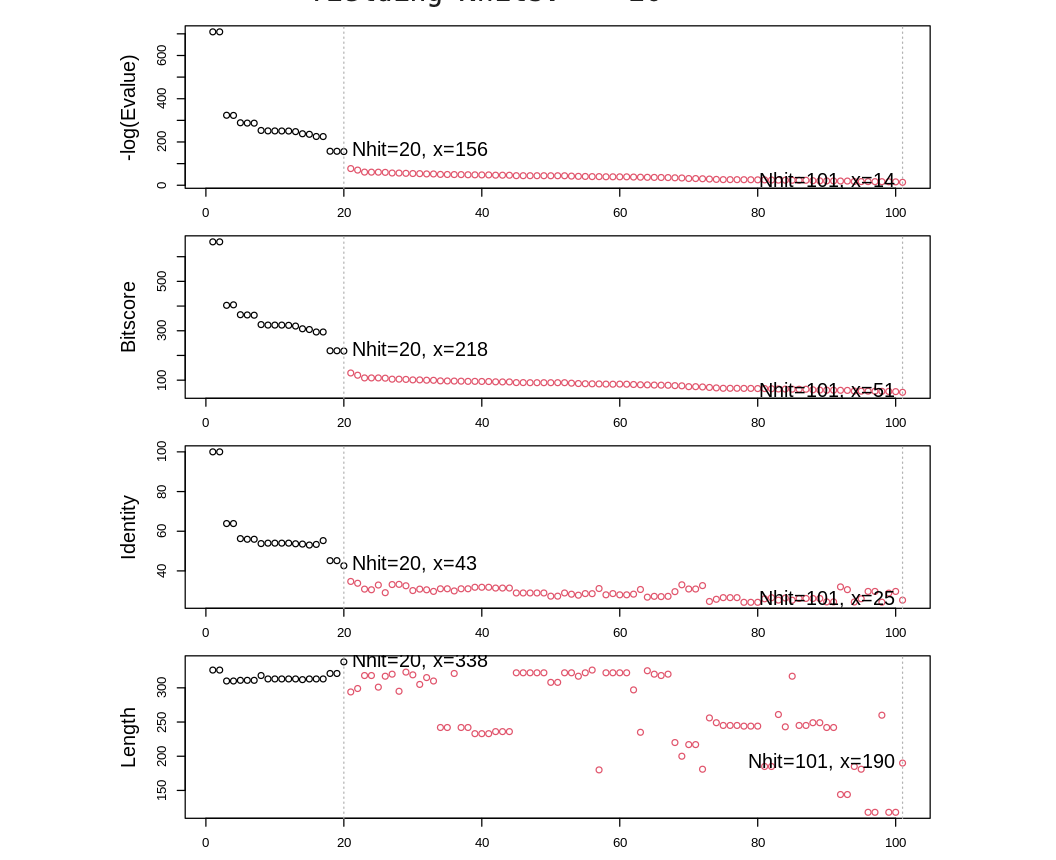

In the data above, there roughly 20 hits that fit the suggestions. Therefore, our cutoff should be around 100.

Remember, you can always come back and change the cutoff if your choice leads to less than ideal results!

---

View the data, and set the cutoff based on the suggestions above.



In [ ]:
hits <- plot.blast(blast, cutoff = 200)

We can now learn a bit about our hits:

In [ ]:
# PDB IDs
head(hits$hits)

The above list are the first 6 PDB codes in the hit group. If you remove the head() around hits$hits, it will display the complete list.



---

Now let's view some details about each of the hits:

In [ ]:
# resolution, ligands, and citrations

anno <- pdb.annotate(hits)
head(anno[, c("resolution", "ligandId", "citation")])


Now we have a list of the details of the PDB files including the citation for each structure. This information would be really helpful if we want to write a report based on these data or if you wanted to exclude certain species from the hits.


---

Let's save the information to a file.


In [ ]:
# write the annotation information to a file and display
write_csv(anno, "outputs/PDB_hits_information.csv")

head(anno)

Now that we have information about the hits, let's download the PDB files and align them.

You will need to fill in your email address where it says `email` in the code block. The PDB files are being aligned in the cloud and the email address helps reduce people mis-using the system.

There will be a long print out of the files and a folder will be created called `raw_pdbs`.

In [ ]:
# Download PDBs and split by chain ID
#files <- get.pdb(hits, path="raw_pdbs", split = TRUE)

# Extract and align sequences
pdbs <- pdbaln(files, web.args=list(email='________'))


If the above fails due to an "Error in .ebi_msa(aln, email = web.args$email, method = prg, protein = protein..." Run the two code blocks below, otherwise it is not needed.

In [ ]:
#@title **If cloud-based alignment fails (SLOW!)...**
#@markdown Press PLAY  and wait for step to finish before moving on.
#@markdown This step takes ~10 minutes to download the programs

install.packages("BiocManager")
library(BiocManager)
BiocManager::install(c("msa", "Biostrings"))

In [ ]:
#@title **Run this block to do the alignment locally (SLOW!)**


# Download PDBs and split by chain ID
#files <- get.pdb(hits, path="raw_pdbs", split = TRUE)

# Extract and align sequences
pdbs <- pdbaln(files, exefile = 'msa')


Now that we have the PDBs aligned, we can describe the alignment in some detail, including the range of sequence identity.

In [ ]:
# Sequence identity
summary(c(seqidentity(pdbs)))

If you find that the minimum identity value is too low, then adjust the cutoff value from earlier, and repeat the steps to now.


---

Now let's look at the conformational clustering of our structures. We will use principle component analysis or PCA for this. First we will find a common core of amino acids/structure to align all the PDB files too. Then we will calculate the principle components. Then we will display the data for comparing the first 3 principle components.

In [ ]:
pc.pdbs <- pca(pdbs, core.find = TRUE, fit = FALSE)
plot(pc.pdbs)

The bottom right plot indicates how much of the differences are represented by different principle components. In the example structure, 1SMK, 84% of the conformation is accounted for in the first 3 principle components. If we expanded our viewing of the principle components to 5, we would cover closer to 95% of the motion.



---

Now let's save the principle components into a dataframe so we can replot them later. Notice how we extract the data into the columns of the data frame using `$` and `[]`.  


In [ ]:
# construct and save the dataframe with PCs 1-5
# $ accesses the list of principle components
# [,1] indicates column
pc1 <- pc.pdbs$z[,1]

# [,2] indicates column 2
pc2 <- pc.pdbs$z[,2]

pc3 <- pc.pdbs$z[,3]
pc4 <- pc.pdbs$z[,4]
pc5 <- pc.pdbs$z[,5]

# get the rownames which correspond to the pdb file name
pc0 <- rownames(pc.pdbs$z)


# make the data frame
pc_df <- tibble(pdb = pc0,
                pc1 = pc1,
                pc2 = pc2,
                pc3 = pc3,
                pc4 = pc4,
                pc5 = pc5)

# clean up the rownames to just be the PDB ID
pc_df <- pc_df |>
  # mutate changes a column, str_sub subsets strings
  # start = -10 means start 10 from the end and end at -5
  mutate(pdb = str_sub(pdb, start = -10, end = -5))


# save the file in outputs
write_csv(pc_df, "outputs/PC_dataframe.csv")

In [ ]:
# view the first 6 rows of the dataframe
head(pc_df)

Now we can perform NMA on this ensemble of PDB files. This allows you to identify proteins which may have different dynamics because the sequence is different.

---

*Note:* You could also do this type of analysis with a series of modeled structures, align them, and then do NMA to identify mutants which alter the protein dynamics.


In [ ]:
modes <- nma(pdbs, rm.gaps=FALSE)

Now plot the data to see how it looks.

In [ ]:
plot(modes)

There are some differences between the different proteins. Any gaps you see are introduced during alignment and are due to differences in protein length.

---

Let's save these data, so that we can plot in a better way later.

In [ ]:
nma_df <- as_tibble(modes$fluctuations)

# get pdb names
nma_df$pdb <- rownames(modes$fluctuations)

#  transpose the data so that it can be plotted easier
nma_dft <- nma_df |>
  # transpose the data
  pivot_longer(!pdb, names_to = "aa", values_to = "rmsf") |>
  pivot_wider(names_from = "pdb", values_from = "rmsf") |>
  # change the aa value to a number
  mutate(aa = str_remove_all(aa, "[V]"))

# save the data
write_csv(nma_dft, "outputs/NMA_PDB_ensemble.csv")

We can also plot the conservation of the PDB files versus amino acid on a scale of 0 to 1. 1 is perfect conservation.

In [ ]:
cons <- conserv(pdbs$ali)

# make a data frame
cons_df <- tibble(aa = seq(from = 1, to = length(cons), by = 1),
                  conservation = cons)
# save the file
write_csv(cons_df, "outputs/conservation.csv")

# rough plot of the data
plot.bio3d(cons, ylab="Conservation")


The correlation between the NMA and the sequence conservation can give some indication about whether there are naturally, conserved dynamic regions in the protein or if they are largely non-conserved. This can indicate whether the dynamic feature has a conserved role in protein function.

---

### What if I want to focus on one specific PDB identified in this part?
In the raw_pdbs folder, there are all of the PDB files used in the analysis above. Further in the split_chain folder, there are the single A chains of each of these PDB files. The code below shows how you could perform NMA on one of those PDB files and save the trajectory as we did before.

In [ ]:
# load the pdb
target <- read.pdb("raw_pdbs/split_chain/1EMD_A.pdb")

# calculate the normal modes for the PDB file
modes <- nma(target)

# roughly plot the normal modes (top row) and the fluctuations (bottom row)
# sse is the secondary structure information taken from the PDB file. SSE is not always available
plot(modes)

# save the trajectory
mktrj(modes, mode=7, pdb=pdb, file = "outputs/target_mode7_traj.pdb")